In [1]:
import pandas as pd
from pgmpy.models import DiscreteBayesianNetwork 
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import matplotlib.pyplot as plt
import networkx as nx
from pyvis.network import Network
import html
from ipywidgets import interact_manual, widgets
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

Data shape: (55692, 27)

Data types:
gender                   int32
age                      int64
height(cm)               int64
weight(kg)               int64
waist(cm)              float64
eyesight(left)         float64
eyesight(right)        float64
hearing(left)          float64
hearing(right)         float64
systolic               float64
relaxation             float64
fasting blood sugar    float64
Cholesterol            float64
triglyceride           float64
HDL                    float64
LDL                    float64
hemoglobin             float64
Urine protein          float64
serum creatinine       float64
AST                    float64
ALT                    float64
Gtp                    float64
oral                     int32
dental caries            int64
tartar                   int32
smoking                  int64
dtype: object


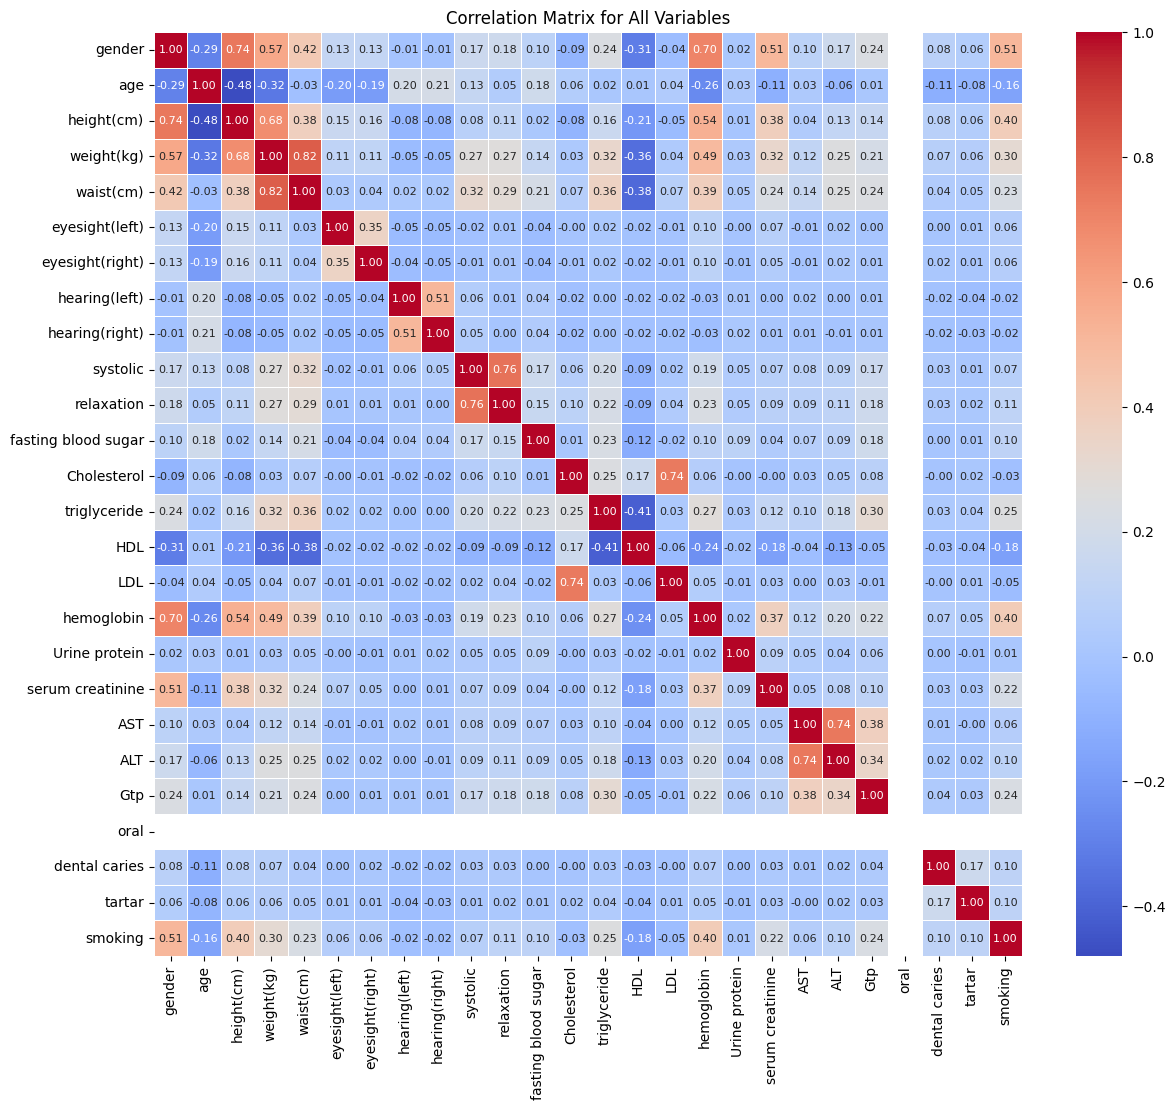


Correlation Matrix:
                       gender       age  height(cm)  weight(kg)  waist(cm)  \
gender               1.000000 -0.290095    0.741556    0.574956   0.419568   
age                 -0.290095  1.000000   -0.479528   -0.324706  -0.026297   
height(cm)           0.741556 -0.479528    1.000000    0.675656   0.378902   
weight(kg)           0.574956 -0.324706    0.675656    1.000000   0.822842   
waist(cm)            0.419568 -0.026297    0.378902    0.822842   1.000000   
eyesight(left)       0.127424 -0.195472    0.151133    0.108433   0.027458   
eyesight(right)      0.125680 -0.192723    0.155665    0.113155   0.037996   
hearing(left)       -0.009407  0.203993   -0.078663   -0.050094   0.023790   
hearing(right)      -0.011579  0.208722   -0.078323   -0.052836   0.019286   
systolic             0.167289  0.134023    0.080585    0.266131   0.316922   
relaxation           0.177891  0.050745    0.113193    0.271634   0.292627   
fasting blood sugar  0.098117  0.182351    

In [2]:
# Завантаження датасету
df = pd.read_csv("smoking.csv")

# Перевірка розміру датасету
print("Data shape:", df.shape)

# Вибір усіх стовпців, крім ID (якщо це індекс)
if 'ID' in df.columns:
    df = df.drop(columns=['ID'])

# Список категоріальних змінних
categorical_columns = ['gender', 'oral', 'tartar', 'smoking']

# Кодування категоріальних змінних
df_encoded = df.copy()
label_encoders = {}
for column in categorical_columns:
    if column in df_encoded.columns:
        le = LabelEncoder()
        df_encoded[column] = le.fit_transform(df_encoded[column])
        label_encoders[column] = le

# Перевірка типів даних
print("\nData types:")
print(df_encoded.dtypes)

# Обчислення кореляційної матриці
correlation_matrix = df_encoded.corr()

# Візуалізація кореляційної матриці
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 8})
plt.title('Correlation Matrix for All Variables')
plt.show()

# Виведення кореляційної матриці у вигляді таблиці
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Виведення кореляцій із цільовою змінною 'smoking'
print("\nCorrelations with 'smoking':")
print(correlation_matrix['smoking'].sort_values(ascending=False))

In [3]:
# Завантаження датасету
df = pd.read_csv("smoking.csv")

# Вибір релевантних атрибутів
data = df[['gender', 'age', 'height(cm)', 'hemoglobin', 'triglyceride', 'dental caries', 'smoking']]

# Перевірка пропущених значень і видалення
data = data.dropna()

# Дискретизація числових змінних
data['age_group'] = pd.cut(data['age'], bins=[0, 30, 50, 100], labels=['young', 'middle', 'old'])
data['height_group'] = pd.cut(data['height(cm)'], bins=[0, 160, 180, 250], labels=['short', 'medium', 'tall'])
data['hemoglobin_group'] = pd.cut(data['hemoglobin'], bins=[0, 13, 17, 20], labels=['low', 'normal', 'high'])
data['triglyceride_group'] = pd.cut(data['triglyceride'], bins=[0, 150, 200, 500], labels=['normal', 'borderline', 'high'])

# Перекодування категоріальних змінних
data['gender'] = data['gender'].map({'M': 0, 'F': 1})

# Підготовка остаточного набору даних
data_final = data[['gender', 'age_group', 'height_group', 'hemoglobin_group', 'triglyceride_group', 'dental caries', 'smoking']]

In [5]:
# Визначення структури мережі
model = DiscreteBayesianNetwork([
    ('gender', 'smoking'),
    ('gender', 'hemoglobin_group'),
    ('age_group', 'smoking'),
    ('age_group', 'triglyceride_group'),
    ('age_group', 'dental caries'),
    ('height_group', 'hemoglobin_group'),
    ('hemoglobin_group', 'smoking'),
    ('triglyceride_group', 'smoking'),
    ('dental caries', 'smoking')
])

# Навчання параметрів моделі
model.fit(data_final, estimator=MaximumLikelihoodEstimator)

# Виконання інференсу
inference = VariableElimination(model)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'gender': 'N', 'age_group': 'O', 'height_group': 'O', 'hemoglobin_group': 'O', 'triglyceride_group': 'O', 'dental caries': 'N', 'smoking': 'N'}


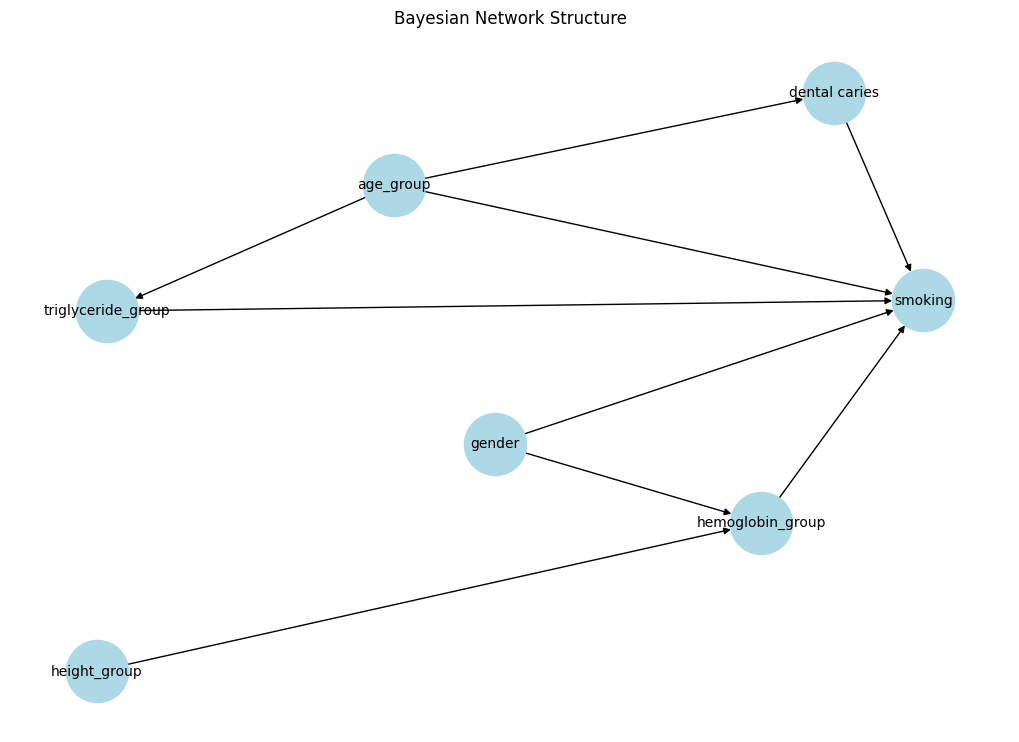

In [6]:
# Візуалізація структури мережі за допомогою networkx
G = nx.DiGraph()
G.add_nodes_from(model.nodes())
G.add_edges_from(model.edges())
pos = nx.spring_layout(G)

plt.figure(figsize=(10, 7))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, arrows=True)
plt.title("Bayesian Network Structure")
plt.axis('off')
plt.show()

In [7]:
# Інтерактивна візуалізація з CPD у підказках за допомогою pyvis
net = Network(notebook=True, directed=True, height='800px', width='100%', bgcolor='#ffffff', font_color='black')
for node in model.nodes():
    try:
        cpd = model.get_cpds(node)
        tooltip = f"<pre>{html.escape(str(cpd))}</pre>"
    except:
        tooltip = node
    net.add_node(node, label=node, title=tooltip, shape='dot', size=25)
for edge in model.edges():
    net.add_edge(*edge)
net.toggle_physics(True)
net.barnes_hut()
net.show("bayesian_network.html")

bayesian_network.html


In [8]:
# Інтерактивне введення evidence через випадаючі меню
root_variables = ['gender', 'age_group', 'height_group']
dropdowns = {}
if "gender" in root_variables:
    dropdowns["gender"] = widgets.Dropdown(options=[("Male", 0), ("Female", 1)], description='Gender:')
if "age_group" in root_variables:
    dropdowns["age_group"] = widgets.Dropdown(options=[("Young", 'young'), ("Middle", 'middle'), ("Old", 'old')], description='Age Group:')
if "height_group" in root_variables:
    dropdowns["height_group"] = widgets.Dropdown(options=[("Short", 'short'), ("Medium", 'medium'), ("Tall", 'tall')], description='Height Group:')

In [9]:
@interact_manual(**dropdowns)
def compute_smoking(**kwargs):
    evidence = kwargs
    try:
        result = inference.query(variables=["smoking"], evidence=evidence)
        print("Inference Result:")
        print(result)
    except Exception as e:
        print(f"Inference failed: {e}")
        return

    # Візуалізація маргінальних розподілів
    cpds = model.get_cpds()
    fig = make_subplots(
        rows=ceil(len(cpds)/2), cols=2,
        subplot_titles=[cpd.variable for cpd in cpds],
        horizontal_spacing=0.15, vertical_spacing=0.2
    )

    row, col = 1, 1
    for cpd in cpds:
        variable = cpd.variable
        try:
            marginal = inference.query(variables=[variable], evidence=evidence)
            states = cpd.state_names[variable]
            probs = marginal.values
        except:
            states = cpd.state_names[variable]
            probs = [0 for _ in states]

        decoded_states = [f"{variable} = {s}" for s in states]
        fig.add_trace(
            go.Bar(x=decoded_states, y=probs, name=variable),
            row=row, col=col
        )

        col += 1
        if col > 2:
            row += 1
            col = 1

    fig.update_layout(height=400*ceil(len(cpds)/2), width=900, title_text="Posterior Distributions given Evidence")
    fig.show()

    # Табличний вивід апостеріорних ймовірностей
    print("Posterior Probabilities (Tabular):")
    for cpd in cpds:
        variable = cpd.variable
        try:
            marginal = inference.query(variables=[variable], evidence=evidence)
            decoded_states = [f"{variable} = {s}" for s in cpd.state_names[variable]]
            df = pd.DataFrame({variable: decoded_states, "P(·|evidence)": marginal.values})
            display(df)
        except:
            continue

    # Візуалізація мережі з апостеріорними ймовірностями
    G = nx.DiGraph()
    G.add_nodes_from(model.nodes())
    G.add_edges_from(model.edges())
    pos = nx.spring_layout(G)

    plt.figure(figsize=(10, 7))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, arrows=True)

    for cpd in cpds:
        variable = cpd.variable
        try:
            marginal = inference.query(variables=[variable], evidence=evidence)
            states = cpd.state_names[variable]
            probs = marginal.values
            label = "\n".join([f"{s}: {p:.2f}" for s, p in zip(states, probs)])
            x, y = pos[variable]
            plt.text(x, y + 0.08, label, fontsize=8, ha='center', bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
        except:
            continue

    plt.title("Bayesian Network with Posterior Probabilities")
    plt.axis('off')
    plt.show()

interactive(children=(Dropdown(description='Gender:', options=(('Male', 0), ('Female', 1)), value=0), Dropdown…